#Set-up environment

In [ ]:
!pip install --upgrade -q git+https://github.com/huggingface/transformers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install --upgrade -q git+https://github.com/huggingface/diffusers

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


#Imports

In [ ]:
import random
from dataclasses import dataclass
from typing import Any, List, Dict, Optional, Union, Tuple

import cv2
import torch
import requests
import numpy as np
from PIL import Image
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from transformers import AutoModelForMaskGeneration, AutoProcessor, pipeline

import diffusers

#Utils

In [ ]:

@dataclass
class BoundingBox:
    xmin: int
    ymin: int
    xmax: int
    ymax: int

    @property
    def xyxy(self) -> List[float]:
        return [self.xmin, self.ymin, self.xmax, self.ymax]

@dataclass
class DetectionResult:
    score: float
    label: str
    box: BoundingBox
    mask: Optional[np.array] = None

    @classmethod
    def from_dict(cls, detection_dict: Dict) -> 'DetectionResult':
        return cls(score=detection_dict['score'],
                   label=detection_dict['label'],
                   box=BoundingBox(xmin=detection_dict['box']['xmin'],
                                   ymin=detection_dict['box']['ymin'],
                                   xmax=detection_dict['box']['xmax'],
                                   ymax=detection_dict['box']['ymax']))

In [ ]:
def mask_to_polygon(mask: np.ndarray) -> List[List[int]]:
    # Find contours in the binary mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    largest_contour = max(contours, key=cv2.contourArea)

    # Extract the vertices of the contour
    polygon = largest_contour.reshape(-1, 2).tolist()

    return polygon

def polygon_to_mask(polygon: List[Tuple[int, int]], image_shape: Tuple[int, int]) -> np.ndarray:
    """
    Convert a polygon to a segmentation mask.

    Args:
    - polygon (list): List of (x, y) coordinates representing the vertices of the polygon.
    - image_shape (tuple): Shape of the image (height, width) for the mask.

    Returns:
    - np.ndarray: Segmentation mask with the polygon filled.
    """
    # Create an empty mask
    mask = np.zeros(image_shape, dtype=np.uint8)

    # Convert polygon to an array of points
    pts = np.array(polygon, dtype=np.int32)

    # Fill the polygon with white color (255)
    cv2.fillPoly(mask, [pts], color=(255,))

    return mask


def load_image(image_str: str) -> Image.Image:
    if image_str.startswith("http"):
        image = Image.open(requests.get(image_str, stream=True).raw).convert("RGB")
    else:
        image = Image.open(image_str).convert("RGB")

    return image


def refine_masks(masks: torch.BoolTensor, polygon_refinement: bool = False) -> List[np.ndarray]:
    masks = masks.cpu().float()
    masks = masks.permute(0, 2, 3, 1)
    masks = masks.mean(axis=-1)
    masks = (masks > 0).int()
    masks = masks.numpy().astype(np.uint8)
    masks = list(masks)

    if polygon_refinement:
        for idx, mask in enumerate(masks):
            shape = mask.shape
            polygon = mask_to_polygon(mask)
            mask = polygon_to_mask(polygon, shape)
            masks[idx] = mask

    return masks


def get_boxes(results: DetectionResult) -> List[List[List[float]]]:
    boxes = []
    for result in results:
        xyxy = result.box.xyxy
        boxes.append(xyxy)

    return [boxes]

#Plot utils

In [ ]:
def annotate(image: Union[Image.Image, np.ndarray], detection_results: List[DetectionResult]) -> np.ndarray:
    # Convert PIL Image to OpenCV format
    image_cv2 = np.array(image) if isinstance(image, Image.Image) else image
    image_cv2 = cv2.cvtColor(image_cv2, cv2.COLOR_RGB2BGR)

    # Iterate over detections and add bounding boxes and masks
    for detection in detection_results:
        label = detection.label
        score = detection.score
        box = detection.box
        mask = detection.mask

        # Sample a random color for each detection
        color = np.random.randint(0, 256, size=3)

        # Draw bounding box
        cv2.rectangle(image_cv2, (box.xmin, box.ymin), (box.xmax, box.ymax), color.tolist(), 2)
        cv2.putText(image_cv2, f'{label}: {score:.2f}', (box.xmin, box.ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color.tolist(), 2)

        # If mask is available, apply it
        if mask is not None:
            # Convert mask to uint8
            mask_uint8 = (mask * 255).astype(np.uint8)
            contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(image_cv2, contours, -1, color.tolist(), 2)

    return cv2.cvtColor(image_cv2, cv2.COLOR_BGR2RGB)

def plot_detections(
    image: Union[Image.Image, np.ndarray],
    detections: List[DetectionResult],
    save_name: Optional[str] = None
) -> None:
    annotated_image = annotate(image, detections)
    plt.imshow(annotated_image)
    plt.axis('off')
    if save_name:
        plt.savefig(save_name, bbox_inches='tight')
    plt.show()

#Grounded Segment Anything (SAM)

In [ ]:
def detect(
    image: Image.Image,
    labels: List[str],
    threshold: float = 0.3,
    detector_id: Optional[str] = None
) -> List[Dict[str, Any]]:
    """
    Use Grounding DINO to detect a set of labels in an image in a zero-shot fashion.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    detector_id = detector_id if detector_id is not None else "IDEA-Research/grounding-dino-tiny"
    object_detector = pipeline(model=detector_id, task="zero-shot-object-detection", device=device)

    labels = [label if label.endswith(".") else label+"." for label in labels]

    results = object_detector(image,  candidate_labels=labels, threshold=threshold)
    results = [DetectionResult.from_dict(result) for result in results]

    return results

def segment(
    image: Image.Image,
    detection_results: List[Dict[str, Any]],
    polygon_refinement: bool = False,
    segmenter_id: Optional[str] = None
) -> List[DetectionResult]:
    """
    Use Segment Anything (SAM) to generate masks given an image + a set of bounding boxes.
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    segmenter_id = segmenter_id if segmenter_id is not None else "facebook/sam-vit-base"

    segmentator = AutoModelForMaskGeneration.from_pretrained(segmenter_id).to(device)
    processor = AutoProcessor.from_pretrained(segmenter_id)

    boxes = get_boxes(detection_results)
    inputs = processor(images=image, input_boxes=boxes, return_tensors="pt").to(device)

    outputs = segmentator(**inputs)
    masks = processor.post_process_masks(
        masks=outputs.pred_masks,
        original_sizes=inputs.original_sizes,
        reshaped_input_sizes=inputs.reshaped_input_sizes
    )[0]

    masks = refine_masks(masks, polygon_refinement)

    for detection_result, mask in zip(detection_results, masks):
        detection_result.mask = mask

    return detection_results

def grounded_segmentation(
    image: Union[Image.Image, str],
    labels: List[str],
    threshold: float = 0.3,
    polygon_refinement: bool = False,
    detector_id: Optional[str] = None,
    segmenter_id: Optional[str] = None
) -> Tuple[np.ndarray, List[DetectionResult]]:
    if isinstance(image, str):
        image = load_image(image)

    image = image.resize((512, 512))

    detections = detect(image, labels, threshold, detector_id)
    detections = segment(image, detections, polygon_refinement, segmenter_id)

    return np.array(image), detections

#Inference

In [ ]:
image_url = "https://img.freepik.com/premium-photo/white-room-with-sofa-3d-rendering-empty-white-wall-background-interior_39358-43.jpg"
labels = ["a sofa"]
threshold = 0.3

detector_id = "IDEA-Research/grounding-dino-tiny"
segmenter_id = "facebook/sam-vit-base"

In [ ]:
image_array, detections = grounded_segmentation(
    image=image_url,
    labels=labels,
    threshold=threshold,
    polygon_refinement=True,
    detector_id=detector_id,
    segmenter_id=segmenter_id
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/689M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/457 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

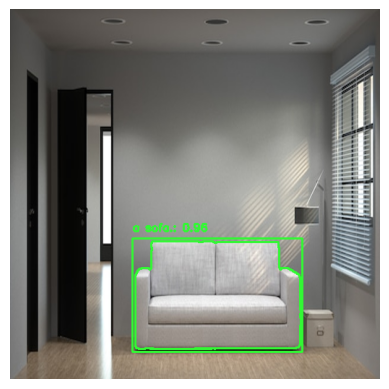

In [ ]:
plot_detections(image_array, detections)

#Cutting out the bounding box with furniture from the image

In [ ]:
bbox = detections[0].box

array([[[ 67,  66,  64],
        [ 69,  68,  66],
        [ 70,  69,  67],
        ...,
        [ 71,  68,  63],
        [ 69,  65,  61],
        [ 68,  64,  61]],

       [[ 67,  66,  64],
        [ 69,  68,  66],
        [ 70,  69,  67],
        ...,
        [ 71,  68,  62],
        [ 68,  65,  61],
        [ 68,  64,  61]],

       [[ 67,  66,  64],
        [ 69,  68,  66],
        [ 70,  69,  67],
        ...,
        [ 70,  67,  61],
        [ 68,  65,  61],
        [ 68,  64,  61]],

       ...,

       [[114, 111, 112],
        [118, 116, 116],
        [119, 118, 116],
        ...,
        [121, 116, 109],
        [120, 117, 111],
        [120, 117, 112]],

       [[116, 112, 113],
        [120, 117, 117],
        [120, 119, 117],
        ...,
        [121, 116, 108],
        [119, 116, 110],
        [119, 116, 111]],

       [[117, 113, 114],
        [121, 118, 118],
        [120, 120, 118],
        ...,
        [121, 117, 107],
        [119, 116, 110],
        [118, 115, 110]]], dtype=uint8)
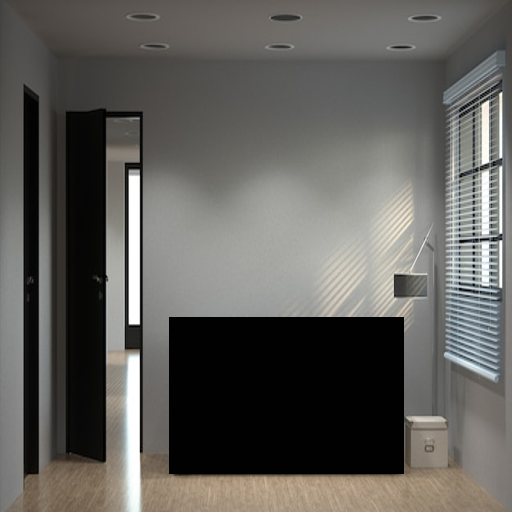

In [ ]:
cropped_image = image_array.copy()
cropped_image[bbox.ymin:bbox.ymax, bbox.xmin:bbox.xmax] = (1, 1, 1)
cropped_image

In [ ]:
sofa = Image.open("Sofa -9.jpg").resize((512, 512))
room = Image.fromarray(cropped_image)
mask = np.zeros((512, 512, 3)).astype(np.uint8)
mask[bbox.ymin:bbox.ymax, bbox.xmin:bbox.xmax] = (255, 255, 255)
mask = Image.fromarray(mask)

In [ ]:
from diffusers import StableDiffusionInpaintPipeline
import torch
from diffusers import AutoPipelineForInpainting

pipe = AutoPipelineForInpainting.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1", torch_dtype=torch.float16, variant="fp16"
).to("cuda")
pipe.load_ip_adapter("h94/IP-Adapter", subfolder="sdxl_models", weight_name="ip-adapter_sdxl.bin")
pipe.set_ip_adapter_scale(0.6)

/usr/local/lib/python3.10/dist-packages/diffusers/models/vq_model.py:20: FutureWarning: `VQEncoderOutput` is deprecated and will be removed in version 0.31. Importing `VQEncoderOutput` from `diffusers.models.vq_model` is deprecated and this will be removed in a future version. Please use `from diffusers.models.autoencoders.vq_model import VQEncoderOutput`, instead.
  deprecate("VQEncoderOutput", "0.31", deprecation_message)
/usr/local/lib/python3.10/dist-packages/diffusers/models/vq_model.py:25: FutureWarning: `VQModel` is deprecated and will be removed in version 0.31. Importing `VQModel` from `diffusers.models.vq_model` is deprecated and this will be removed in a future version. Please use `from diffusers.models.autoencoders.vq_model import VQModel`, instead.
  deprecate("VQModel", "0.31", deprecation_message)


model_index.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


  0%|          | 0/200 [00:00<?, ?it/s]

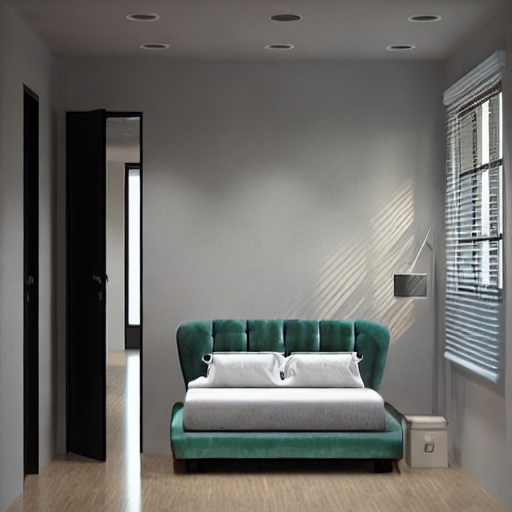

In [ ]:
images = pipe(
    prompt="bed in the room",
    image=room,
    mask_image=mask,
    ip_adapter_image=sofa,
    num_inference_steps=200,
).images
images[0]

#Cutting out the furniture from an image

array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]]], dtype=uint8)
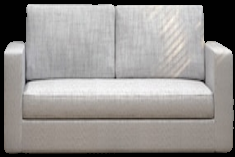

In [ ]:
furniture_element = image_array.copy()
furniture_element[detections[0].mask == False] = (1, 1, 1)
furniture_element = furniture_element[bbox.ymin:bbox.ymax, bbox.xmin:bbox.xmax]
furniture_element